# Preparation

This project aims on using Deep Learning with Kullback-Leibler Divergence. Some basic packages are required for this project. The aim of the following chunk is to install required packages such as `lifelines`, `sklearn-pandas` and `torchtuples`. Note that `pycox` is built based on `torchtuples`.

---

`pycox` should be pre-installed and moved into the google drive since we need to modify part of the code in this package for our model.

In [1]:
!pwd
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
! pip install statsmodels --upgrade
# ! pip install pycox

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.4 MB/s 
     |████████████████████████████████| 68 kB 4.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=c253e20f7701a806aa55fbafc58ff79b5a6f481159977ccc66d74b6ebcc3c896
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is inco

`pycox` is pre-installed in /content/drive/MyDrive/pycox, before that we need to track the data in google drive.

In [2]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/pycox"
# %pwd
# from pycox.models import LogisticHazard

Mounted at /content/drive
/content/drive/MyDrive/pycox


In [58]:
import os
import sys

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks
from torch import nn
import torch.nn.functional as F 
import torchtuples as tt # Some useful functions

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from pycox.datasets import metabric
from pycox.datasets import support
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

If you have mounted the data rightly, you should print out the list for files in given folder. For example, this will print out all files in `/content/drive/My Drive/Kevin He`

In [5]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['Deep Learning with KL Divergence: General Tutorial.ipynb', 'local_data.csv', 'prior_data.csv', 'local_data_2.csv', 'local_data_3.csv', 'prior_data_subset.csv', 'prior_data_subset_2.csv', 'prior_data_subset_3.csv', 'R-code.ipynb', 'local_data_together.csv', 'Untitled', 'Deep Learning with KL Divergence Simulation Image Data.ipynb', 'Deep Learning with KL Divergence.ipynb', 'Deep Learning with KL Divergence Real Data.ipynb', 'prior_data_subset_4.csv', 'Deep Learning with KL Divergence Simulation Non-linear-prop.ipynb', 'Deep Learning with KL Divergence Non-linear Visualization.ipynb', 'prior_data_subset_5.csv', 'Deep Learning with KL-divergence Real Data: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 1: Tutorial', 'Deep Learning with KL Divergence Simulation 2-1: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 3: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 2-2: Tutorial.ipynb']


# What is Prior and Local?

To use our model, we need to define the concepts of prior and local. Prior data is used for training prior model and the hazard rates of it will be used to obtain the value of our loss function. It can be any model such as a deep learning model or a Generalized Linear Model (GLM), we only require the hazard rates that obtained from our trained prior model.

In the following part, we show how to train our model with SUPPORT data. For this data, we sample most of the data as prior data and the remaining part are local. For our model, the local data and the prior information will be used. For other models, only local data is accessible. 

You can also train our discrete-time model, just make sure the model can provide with a matrix $\lambda \in \mathbb R^{n \times K}$, with $n$ the number of observations and $K$ the number of time intervals.

# Data Preparation: Splitting Prior and Local

SUPPORT data is a data with time a continuous value (maximal value $2029$), which is not the traditional case that discrete-time model can deal with. Here we want to generate 20 (`num_durations = 20`) time intervals by grouping the continuous event time by quantiles. The cuts are defined by the whole dataset. We will cover the discrete time on the original continuous time, which means `duration` will be alternated by our discrete time $0, 1, 2, \ldots, 19$.

We will also sample 90% of the data as prior and the remaining 10% is local data.

In [7]:
data = support.read_df()

In [9]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,30.0,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,1527.0,0
2,23.399990,1.0,2.0,3.0,0.0,0.0,1.0,87.0,144.0,45.0,37.296879,130.0,5.199219,1.199951,96.0,1
3,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927,892.0,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,7.0,1


In [10]:
num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(data))

data["duration"] = y_train[0]

In [11]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,7,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,18,0
2,23.399990,1.0,2.0,3.0,0.0,0.0,1.0,87.0,144.0,45.0,37.296879,130.0,5.199219,1.199951,11,1
3,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927,16,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,3,1


You can see the boundaries for each time interval by `labtrans.cuts`.

In [12]:
labtrans.cuts

array([   0.,    3.,    5.,    8.,   11.,   16.,   23.,   32.,   46.,
         66.,   95.,  138.,  195.,  268.,  380.,  533.,  754., 1027.,
       1387., 2029.], dtype=float32)

In [13]:
# Here ratio means that of prior data, which means 10% of the data is local data.
ratio = 0.9

df_prior = data.sample(frac = ratio)
df_local = data.drop(df_prior.index)

df_local = df_local.reset_index(drop = True)

# Train Prior Model

Firstly we need to train a prior model, a NN with prior data as input and 20% of them is used for validation (early stopping). Note that we have categorical but not binary features in SUPPORT, wherer we need to make sure they are not affected by standardization. Moreover, we need to transfer them to `int64`. 

In [96]:
# Only for simplicity and unity, nvm.

data_prior = df_prior.copy()

In [97]:
data_prior_val = data_prior.sample(frac=0.2)
data_prior_train = data_prior.drop(data_prior_val.index)

In [98]:
# There are 3 kinds of features: continuous, binary and categorical. Each one requires different ways to preprocess

cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical] # we need a separate mapper to ensure the data type 'int64'

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(data_prior_train)
x_val = x_transform(data_prior_val)

In [99]:
# The data type for event times should be float32, DO NOT CHANGE THAT!

get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
y_train = get_target(data_prior_train)
y_val = get_target(data_prior_val)

`train` and `val` are training and validation data that used for prior model training.

In [100]:
train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

For the next step we need to build our deep learning model. Due to the existence of categorical features, we use embedding to do feature transformation for these features. The transformed features will be combined into other features and then served as input for main fully-connected neural network model.

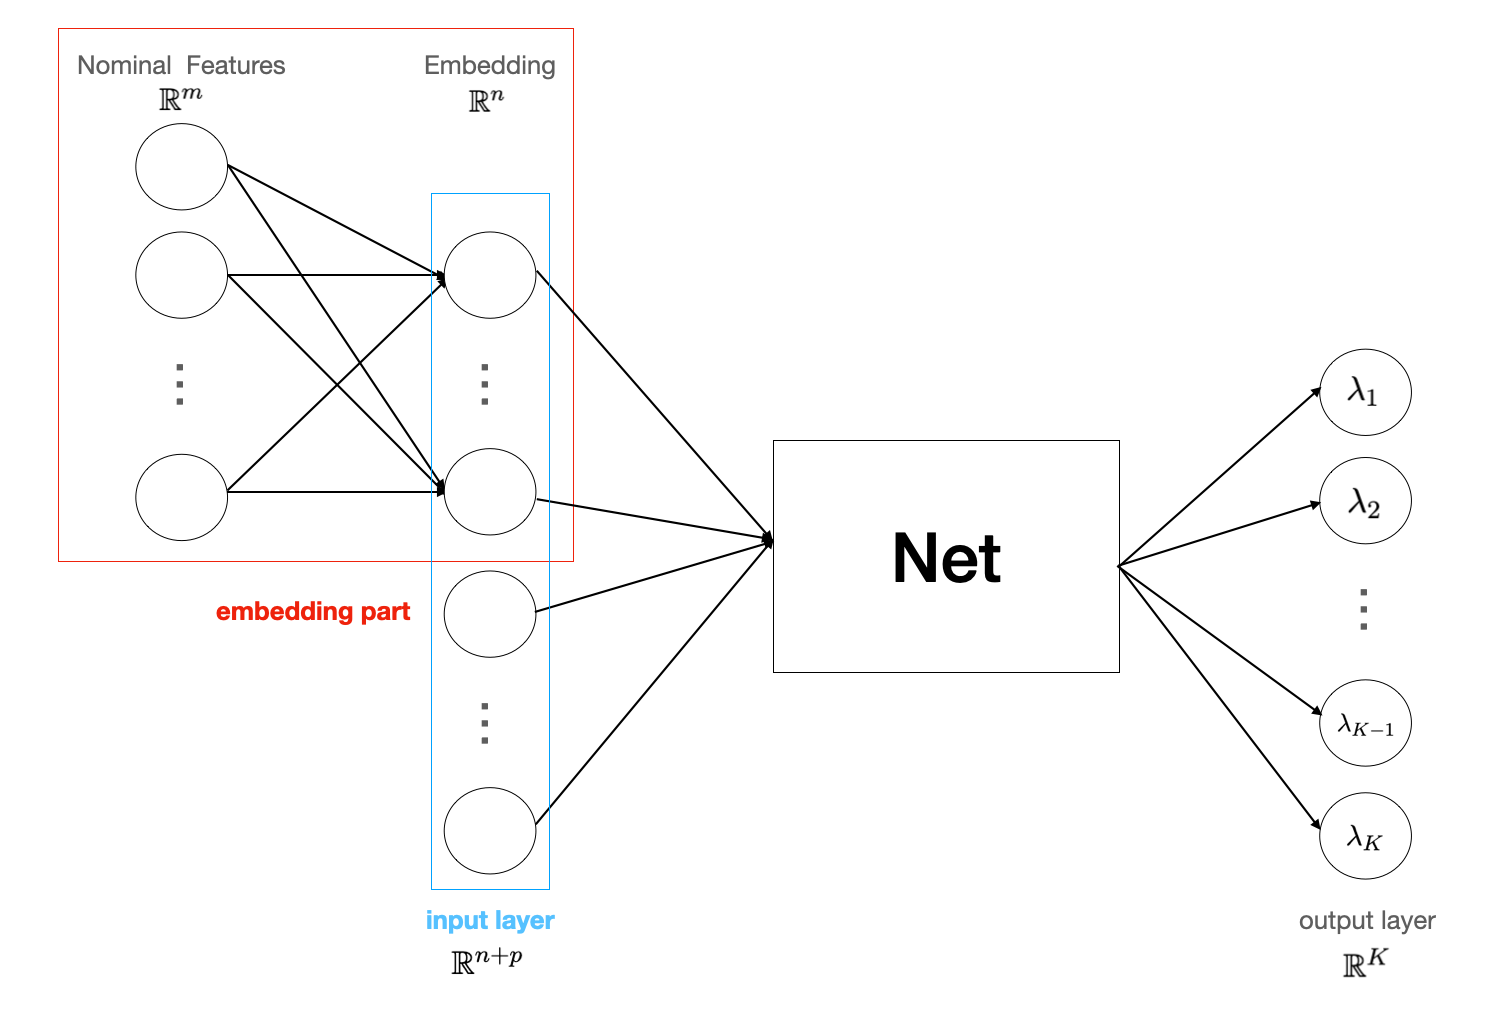

We will also store `num_embeddings` and `embedding_dims` for the usage of output of this model when applying it on the local data.

In [101]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

num_embeddings, embedding_dims

(array([8, 7, 4]), array([4, 3, 2]))

In [102]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(8, 4)
      (1): Embedding(7, 3)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [103]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)
model.optimizer.set_lr(0.01)

batch_size = 256

In [104]:
# For early stopping, we will use EarlyStoppingCycle which work in the same manner as EarlyStopping but will stop at the end of the cycle if the current best model was not obtained in the current cycle.

epochs = 512
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = False # set to True if you want to print out logs

In [105]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

# Combine Prior Information for Model Training

Similarly, we sample out training, validation and test data from local data. Note that we need to compute `combined_info` and send it into the model to compute our loss function. 

The data preprocessing parts for local data is the same as what we have done for prior data.

In [106]:
df_test = df_local.sample(frac=0.2)
df_train = df_local.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [107]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

`model.predict_hazard` is used for generating prior information. The number of columns should be the same as the number of time intervals (`num_durations`).

In [108]:
prior_info_train = model.predict_hazard(x_train)
prior_info_val = model.predict_hazard(x_val)

data_local_train_index = np.array(df_train.index)
data_local_val_index = np.array(df_val.index)

time = df_local["duration"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], num_durations)) # 21 - 1 = 20
np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
zeros

zeros_train = zeros[data_local_train_index]
zeros_val = zeros[data_local_val_index]

eta = 20
combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

We need to train a model for local data, but note that the embedding structure should be the same as prior model, using `num_embeddings` and `embedding_dims` that defined before.

In [114]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(8, 4)
      (1): Embedding(7, 3)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [115]:
n_train = df_train.shape[0]
n_val = df_val.shape[0]

y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

# durations_test, events_test are used for evaluation
durations_test, events_test = get_target(df_test)

We need to define a new loss for our model.

In [122]:
class NewlyDefinedLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def newly_defined_loss(self, phi, combined_info, idx_durations, events):

      if events.dtype is torch.bool:
          events = events.float()
      events = events.view(-1, 1)
      idx_durations = idx_durations.view(-1, 1)
      # y_bce = torch.zeros_like(phi).scatter(1, idx_durations, events)  # TODO: Data Expansion!
      bce = F.binary_cross_entropy_with_logits(phi, combined_info, reduction='none')
      loss = bce.cumsum(1).gather(1, idx_durations).view(-1)
      return loss.mean()
        
    def forward(self, phi, combined_info, idx_durations, events):
        return self.newly_defined_loss(phi, combined_info, idx_durations, events)

loss = NewlyDefinedLoss()

In [123]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, loss = loss)

batch_size = 100

epochs = 300
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = False # set to True if you want printout

model.optimizer.set_lr(0.01)

In [124]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 8.6202,	val_loss: 8.3971
1:	[0s / 0s],		train_loss: 8.0556,	val_loss: 7.7086
2:	[0s / 0s],		train_loss: 7.6684,	val_loss: 7.4935
3:	[0s / 0s],		train_loss: 7.2946,	val_loss: 6.6868
4:	[0s / 0s],		train_loss: 6.4858,	val_loss: 6.0126
5:	[0s / 0s],		train_loss: 5.9722,	val_loss: 5.7565
6:	[0s / 0s],		train_loss: 5.7905,	val_loss: 5.7470
7:	[0s / 0s],		train_loss: 5.4189,	val_loss: 4.9280
8:	[0s / 0s],		train_loss: 4.5554,	val_loss: 4.1488
9:	[0s / 0s],		train_loss: 3.9877,	val_loss: 3.6424
10:	[0s / 0s],		train_loss: 3.4676,	val_loss: 3.3035
11:	[0s / 0s],		train_loss: 3.2801,	val_loss: 3.1168
12:	[0s / 0s],		train_loss: 3.1841,	val_loss: 3.0412
13:	[0s / 0s],		train_loss: 3.1579,	val_loss: 3.0038
14:	[0s / 1s],		train_loss: 3.0669,	val_loss: 2.9962
15:	[0s / 1s],		train_loss: 2.9958,	val_loss: 2.8355
16:	[0s / 1s],		train_loss: 2.8188,	val_loss: 2.7135
17:	[0s / 1s],		train_loss: 2.7270,	val_loss: 2.6336
18:	[0s / 1s],		train_loss: 2.6582,	val_loss: 2.5931
19:

# Evaluation

We can draw a graph to see whether our training plot is normal.

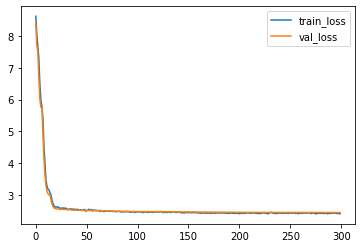

In [130]:
_ = log.plot()

Generally, 3 evaluation metrics are used: Concordance-Index, Integrated_brier_score and Integrated Negative Binomial Log Likelihood.

In [125]:
surv = model.predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [126]:
ev.concordance_td('antolini')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


0.6725940561455503

In [127]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [128]:
ev.integrated_brier_score(time_grid)

0.16212855039351629

In [129]:
ev.integrated_nbll(time_grid)

0.4851347958174234